In [1]:
import pandas as pd
merged_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/sythesize_from_scratch/test_merged_data.csv")

In [ ]:
n_users_subset = 2000  # Number of users for the first dataset
all_user_ids = merged_df['user_id'].unique()
np.random.shuffle(all_user_ids)  # Shuffle user IDs
user_ids_1 = all_user_ids[:n_users_subset]  # First 2,000 users
user_ids_2 = all_user_ids[n_users_subset:]  # Remaining users

# Create user DataFrames
test_df = merged_df[merged_df['user_id'].isin(user_ids_1)].copy()
train_df = merged_df[merged_df['user_id'].isin(user_ids_2)].copy()
# Cleaning logic for user_interests and title
def clean_text(text):
    if not isinstance(text, str):
        return "unknown"
    text = text.lower().strip()
    text = text.replace(',', ' ')
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text)     # collapse multiple spaces
    return text if text else "unknown"

def clean_text_columns(df):
    if 'title' in df.columns:
        df["title"] = df["title"].apply(lambda x: clean_text(x) if isinstance(x, str) and x.strip() else "unknown")
    if 'user_interests' in df.columns:
        df["user_interests"] = df["user_interests"].apply(
            lambda x: clean_text(x) if isinstance(x, str) and x.strip() else "unknown")
        
    return df
clean_text_columns(train_df)
clean_text_columns(test_df)

## <span style="color:#ff5f27">🧬 Train Retrieval Model </span>



## <span style="color:#ff5f27">📝 Imports </span>


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import StringLookup, Normalization
import tensorflow_recommenders as tfrs
import pandas as pd
import numpy as np
import hopsworks
import warnings
import re
warnings.filterwarnings('ignore')

## <span style="color:#ff5f27">🔮 Connect to Hopsworks Feature Store </span>

In [4]:

# Connect to Hopsworks Feature Store
project = hopsworks.login()
fs = project.get_feature_store()



2025-05-13 14:51:24,999 INFO: Initializing external client
2025-05-13 14:51:25,000 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-05-13 14:51:27,170 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1220788


---

## <span style="color:#ff5f27">🔪 Feature Selection </span>


In [3]:
import tensorflow as tf
import pandas as pd

# Load from Hopsworks feature groups
users_fg = fs.get_feature_group(name="users", version=1)
events_fg = fs.get_feature_group(name="events", version=1)
interactions_fg = fs.get_feature_group(name="interactions", version=1)


In [5]:

# Define features for query and candidate towers (retrieval model only)
QUERY_FEATURES = ["user_id", "user_city", "age"]
CANDIDATE_FEATURES = ["event_id", "event_type", "event_city"]


In [ ]:

# Join user + event features with interactions
selected_features = interactions_fg.select(["interaction_id"])\
    .join(users_fg.select(QUERY_FEATURES), on="user_id")\
    .join(events_fg.select(CANDIDATE_FEATURES), on="event_id")


## <span style="color:#ff5f27">⚙️ Feature View Creation </span>


In [ ]:

# Create feature view
feature_view = fs.create_feature_view(
    name='event_retrieval_2',
    version=1,
    query=selected_features,
)


In [6]:

# Create feature view
feature_view = fs.get_feature_view(
    name='event_retrieval_2',
    version=1,
)

## <span style="color:#ff5f27">🏋️ Training Dataset </span>


In [7]:

# Split dataset
train_df, val_df, test_df, _, _, _ = feature_view.train_validation_test_split(
    validation_size=0.1, 
    test_size=0.01,
    description='Event retrieval dataset splits',
)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (6.79s) 


In [14]:

# Build tf.data.Dataset
def df_to_ds(df):
    return tf.data.Dataset.from_tensor_slices({col: df[col].values for col in df.columns})

BATCH_SIZE = 1024
train_ds = df_to_ds(train_df).batch(BATCH_SIZE).cache().shuffle(BATCH_SIZE * 10)
val_ds = df_to_ds(test_df).batch(BATCH_SIZE).cache()

# Prepare vocabulary lists for Lookup & Embedding layers
user_id_list = train_df["user_id"].unique().tolist()
event_id_list = train_df["event_id"].unique().tolist()
user_city_list = train_df["user_city"].unique().tolist()
event_city_list = train_df["event_city"].unique().tolist()
event_type_list = train_df["event_type"].unique().tolist()
#user_interest_list = train_df["user_interests"].unique().tolist()

# Print summary
print(f"✅ Training set size: {len(train_df)}")
print(f"📌 Unique Users: {len(user_id_list)}, Events: {len(event_id_list)}")


✅ Training set size: 147551
📌 Unique Users: 24973, Events: 15397


## <span style="color:#ff5f27">🏰 Two Tower Model </span>


In [8]:
# Recreate your retrieval model in the structure you specified, using your naming conventions and architecture
import tensorflow as tf
import tensorflow_recommenders as tfrs
from typing import Dict

EMBED_DIM = 64
BATCH_SIZE = 1024


# Build tf.data.Dataset
def df_to_ds(df):
    return tf.data.Dataset.from_tensor_slices({col: df[col].values for col in df.columns})

BATCH_SIZE = 1024
train_ds = df_to_ds(train_df).batch(BATCH_SIZE).cache().shuffle(BATCH_SIZE * 10)
val_ds = df_to_ds(test_df).batch(BATCH_SIZE).cache()

# Prepare vocabulary lists for Lookup & Embedding layers
user_id_list = train_df["user_id"].unique().tolist()
event_id_list = train_df["event_id"].unique().tolist()
user_city_list = train_df["user_city"].unique().tolist()
event_city_list = train_df["event_city"].unique().tolist()
event_type_list = train_df["event_type"].unique().tolist()
#user_interest_list = train_df["user_interests"].unique().tolist()

# Print summary
print(f"✅ Training set size: {len(train_df)}")
print(f"📌 Unique Users: {len(user_id_list)}, Events: {len(event_id_list)}")

# Query Tower
class QueryTower(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb_dim = EMBED_DIM

        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=user_id_list, mask_token=None),
            tf.keras.layers.Embedding(len(user_id_list) + 1, self.emb_dim)
        ])

        self.normalized_age = tf.keras.layers.Normalization(axis=None)

        self.city_tokenizer = tf.keras.layers.StringLookup(vocabulary=user_city_list, mask_token=None)

        #self.interest_vectorizer = tf.keras.layers.TextVectorization(output_mode="int", max_tokens=100)
        self.interest_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=100,
            output_mode='multi_hot'
        )

        self.interest_embedding = tf.keras.layers.Embedding(input_dim=100, output_dim=self.emb_dim)

        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(self.emb_dim)
        ])

    def call(self, inputs: Dict[str, tf.Tensor]) -> tf.Tensor:
        city_embedding = tf.one_hot(self.city_tokenizer(inputs["user_city"]), len(user_city_list))
        interests_encoded = self.interest_vectorizer(inputs["user_interests"])
        interests_embedding = self.interest_embedding(interests_encoded)
        pooled_interests = tf.reduce_mean(interests_embedding, axis=1)

        combined = tf.concat([
            self.user_embedding(inputs["user_id"]),
            tf.reshape(self.normalized_age(inputs["age"]), (-1, 1)),
            city_embedding,
            pooled_interests
        ], axis=1)

        return self.fnn(combined)

#query_model = QueryTower()

# Item Tower
class ItemTower(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb_dim = EMBED_DIM

        self.event_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_id_list, mask_token=None),
            tf.keras.layers.Embedding(len(event_id_list) + 1, self.emb_dim)
        ])

        self.type_tokenizer = tf.keras.layers.StringLookup(vocabulary=event_type_list, mask_token=None)
        self.city_tokenizer = tf.keras.layers.StringLookup(vocabulary=event_city_list, mask_token=None)

        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(self.emb_dim)
        ])

    def call(self, inputs: Dict[str, tf.Tensor]) -> tf.Tensor:
        type_embedding = tf.one_hot(self.type_tokenizer(inputs["event_type"]), len(event_type_list))
        city_embedding = tf.one_hot(self.city_tokenizer(inputs["event_city"]), len(event_city_list))

        combined = tf.concat([
            self.event_embedding(inputs["event_id"]),
            type_embedding,
            city_embedding
        ], axis=1)

        return self.fnn(combined)

item_df = train_df[CANDIDATE_FEATURES]
item_df.drop_duplicates(subset="event_id", inplace=True)
item_ds = df_to_ds(item_df)
# Final Two-Tower Model
class TwoTowerModel(tf.keras.Model):
    def __init__(self, query_model, item_model):
        super().__init__()
        self.query_model = query_model
        self.item_model = item_model
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates = item_ds.batch(BATCH_SIZE).map(
                    lambda x: (x["event_id"], self.item_model(x))
                )

            )
        )

    def train_step(self, batch) -> tf.Tensor:
        # Set up a gradient tape to record gradients.
        with tf.GradientTape() as tape:

            # Loss computation.
            user_embeddings = self.query_model(batch)
            item_embeddings = self.item_model(batch)
            loss = self.task(
                user_embeddings, 
                item_embeddings,
                compute_metrics=False,
            )

            # Handle regularization losses as well.
            regularization_loss = sum(self.losses)

            total_loss = loss + regularization_loss

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        metrics = {
            "loss": loss,
            "regularization_loss": regularization_loss,
            "total_loss": total_loss
        }

        return metrics

    def test_step(self, batch) -> tf.Tensor:
        # Loss computation.
        user_embeddings = self.query_model(batch)
        item_embeddings = self.item_model(batch)

        loss = self.task(
            user_embeddings, 
            item_embeddings,
            compute_metrics=True,
        )

        # Handle regularization losses as well.
        regularization_loss = sum(self.losses)

        total_loss = loss + regularization_loss

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss

        return 
    
from tensorflow.keras.callbacks import EarlyStopping
# Create a TwoTowerModel with the specified query_model and item_model
model = TwoTowerModel(query_model, item_model)

# Define an optimizer using AdamW with a learning rate of 0.01
optimizer = tf.keras.optimizers.AdamW(
    weight_decay=0.001, 
    learning_rate=0.001,
)

# Compile the model using the specified optimizer
model.compile(optimizer=optimizer)

# Train the model
early_stop = EarlyStopping(
    monitor="val_factorized_top_k/top_10_categorical_accuracy",
    mode="max",
    patience=10,
    restore_best_weights=True
)
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    callbacks=[early_stop], 
                    epochs=20)

# Evaluate final performance
eval_results = model.evaluate(
    val_ds,
    return_dict=True
)
print("\nFinal Evaluation Metrics:")
for metric, value in eval_results.items():
    print(f"{metric}: {value:.4f}")

✅ Training set size: 147551
📌 Unique Users: 24972, Events: 15401


NameError: name 'query_model' is not defined

In [9]:
item_model = ItemTower()

item_df = train_df[CANDIDATE_FEATURES]
item_df.drop_duplicates(subset="event_id", inplace=True)
item_ds = df_to_ds(item_df)

item_model(next(iter(item_ds.batch(1))))

InvalidArgumentError: Exception encountered when calling layer 'item_tower' (type ItemTower).

cannot compute ConcatV2 as input #1(zero-based) was expected to be a half tensor but is a float tensor [Op:ConcatV2] name: concat

Call arguments received by layer 'item_tower' (type ItemTower):
  • inputs={'event_id': 'tf.Tensor(shape=(1,), dtype=string)', 'event_type': 'tf.Tensor(shape=(1,), dtype=string)', 'event_city': 'tf.Tensor(shape=(1,), dtype=string)'}

In [16]:
query_model = QueryTower()

query_model.normalized_age.adapt(train_ds.map(lambda x : x["age"]))
#query_model.interest_vectorizer.adapt(train_ds.map(lambda x: x["user_interests"]))
#Initialize model with inputs.
query_df = train_df[QUERY_FEATURES]
query_ds = df_to_ds(query_df).batch(1)
query_model(next(iter(query_ds)))

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[-0.14273648,  0.09210932, -0.01863864, -0.18334746, -0.0665916 ,
        -0.03353995,  0.06258664, -0.0825239 , -0.03164114,  0.00591038,
        -0.05126978, -0.04339375,  0.05611509, -0.24926096,  0.1600969 ,
         0.12212038, -0.09264675,  0.00372167, -0.04467791, -0.04419688,
         0.20455375,  0.11671725,  0.07392306, -0.08777661, -0.0826163 ,
        -0.09959766, -0.08821075,  0.02963507, -0.03155496,  0.04036742,
         0.08084628, -0.02529929,  0.06265636,  0.06461073,  0.07849467,
        -0.06585006,  0.0433568 , -0.06330253, -0.0463144 , -0.04614969,
        -0.0888321 , -0.1093106 ,  0.09646111,  0.03317719, -0.10331804,
         0.07465298,  0.09257884,  0.05464227, -0.07720217,  0.06970944,
         0.13546495,  0.12062255, -0.07463525,  0.03230387, -0.01332577,
        -0.01178626,  0.03121089, -0.03260201, -0.16763462, -0.0597887 ,
         0.05026699, -0.03310478, -0.05461213, -0.04882941]],
      dtype=f

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Create a TwoTowerModel with the specified query_model and item_model
model = TwoTowerModel(query_model, item_model)

# Define an optimizer using AdamW with a learning rate of 0.01
optimizer = tf.keras.optimizers.AdamW(
    weight_decay=0.001, 
    learning_rate=0.001,
)

# Compile the model using the specified optimizer
model.compile(optimizer=optimizer)

# Train the model
early_stop = EarlyStopping(
    monitor="val_factorized_top_k/top_10_categorical_accuracy",
    mode="max",
    patience=10,
    restore_best_weights=True
)
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    callbacks=[early_stop], 
                    epochs=20)

# Evaluate final performance
eval_results = model.evaluate(
    val_ds,
    return_dict=True
)
print("\nFinal Evaluation Metrics:")
for metric, value in eval_results.items():
    print(f"{metric}: {value:.4f}")

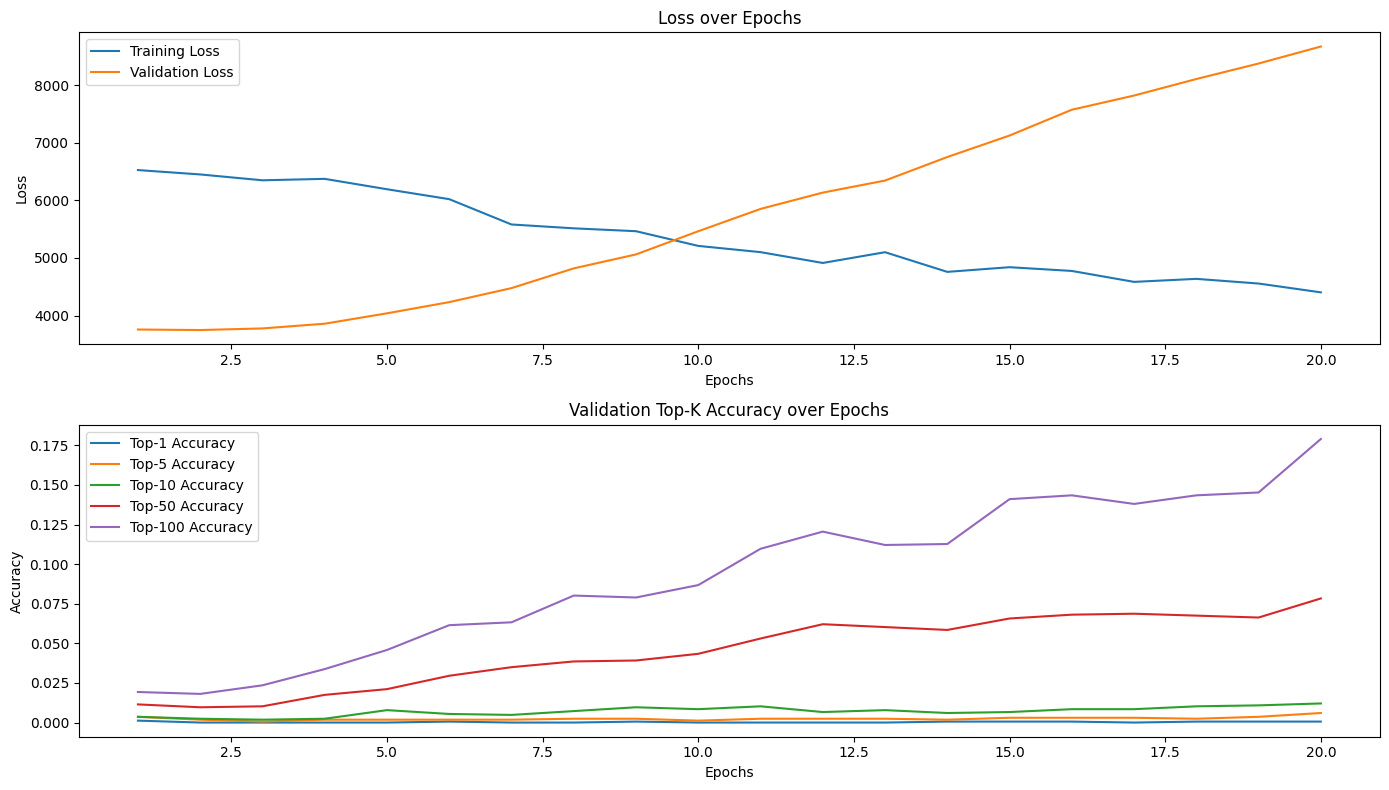

In [20]:
import matplotlib.pyplot as plt


# Plotting function
def plot_metrics(history):
    epochs = range(1, len(history["loss"]) + 1)

    plt.figure(figsize=(14, 8))

    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, history["loss"], label="Training Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Top-K Accuracies
    plt.subplot(2, 1, 2)
    for k in [1, 5, 10, 50, 100]:
        metric = f"val_factorized_top_k/top_{k}_categorical_accuracy"
        plt.plot(epochs, history[metric], label=f"Top-{k} Accuracy")

    plt.title("Validation Top-K Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function to plot
#plot_metrics(history)
plot_metrics(history.history)


In [22]:
import tensorflow as tf
import tensorflow_recommenders as tfrs
import numpy as np
from tensorflow.keras import layers
from typing import Dict, Text
import os
import time

# Custom optimizer with lookahead
class Lookahead(tf.keras.optimizers.Optimizer):
    def __init__(self, optimizer, sync_period=6, slow_step_size=0.5, name="Lookahead", **kwargs):
        super(Lookahead, self).__init__(name, **kwargs)
        self.optimizer = optimizer
        self._sync_period = sync_period
        self._slow_step_size = slow_step_size
        self._step_count = 0
        
    def _create_slots(self, var_list):
        self.optimizer._create_slots(var_list)
        for var in var_list:
            self.add_slot(var, 'slow')
    
    def _prepare_local(self, var_device, var_dtype, apply_state):
        return self.optimizer._prepare_local(var_device, var_dtype, apply_state)
    
    def _resource_apply_dense(self, grad, var, apply_state=None):
        result = self.optimizer._resource_apply_dense(grad, var, apply_state)
        
        # Update slow weights
        if self._step_count % self._sync_period == 0:
            slow_var = self.get_slot(var, 'slow')
            new_val = var + self._slow_step_size * (slow_var - var)
            slow_var_update = slow_var.assign(new_val)
            
        self._step_count += 1
        return result
    
    def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
        result = self.optimizer._resource_apply_sparse(grad, var, indices, apply_state)
        
        # Update slow weights
        if self._step_count % self._sync_period == 0:
            slow_var = self.get_slot(var, 'slow')
            new_val = var + self._slow_step_size * (slow_var - var)
            slow_var_update = slow_var.assign(new_val)
            
        self._step_count += 1
        return result
    
    def get_config(self):
        config = {
            'sync_period': self._sync_period,
            'slow_step_size': self._slow_step_size,
            'optimizer': tf.keras.optimizers.serialize(self.optimizer),
        }
        base_config = super(Lookahead, self).get_config()
        return {**base_config, **config}

# Query Tower for user representation
class QueryTower(tf.keras.Model):
    def __init__(self):
        super(QueryTower, self).__init__()
        
        # User ID embedding with regularization
        self.user_embedding = tf.keras.layers.Embedding(
            input_dim=100000 + 1,  # +1 for OOV token
            output_dim=128,
            embeddings_regularizer=tf.keras.regularizers.l2(1e-5),
            name="user_embedding"
        )
        
        # Age normalization
        self.age_normalization = tf.keras.layers.Normalization(
            axis=-1, mean=30.0, variance=100.0  # Assuming mean age 30, variance 100
        )
        
        # City embedding
        self.city_embedding = tf.keras.layers.Embedding(
            input_dim=1000 + 1,  # +1 for OOV token
            output_dim=64,
            embeddings_regularizer=tf.keras.regularizers.l2(1e-5),
            name="city_embedding"
        )
        
        # Interest embedding with n-gram processing
        self.interest_embedding = tf.keras.Sequential([
            tf.keras.layers.Embedding(
                input_dim=5000 + 1,  # +1 for OOV token
                output_dim=64,
                embeddings_regularizer=tf.keras.regularizers.l2(1e-5),
                name="interest_embedding"
            ),
            tf.keras.layers.GlobalAveragePooling1D()  # Better pooling of variable-length inputs
        ])
        
        # Deeper FNN with residual connections and better regularization
        self.fnn = self._build_fnn()
        
    def _build_fnn(self):
        """Build a deeper FNN with residual connections"""
        # Define the expected input dimension - this should match the concatenated embeddings size
        input_dim = 256  # Adjust this value based on your actual embedding dimensions
        
        inputs = tf.keras.Input(shape=(input_dim,))
        x = tf.keras.layers.Dense(256, activation=None)(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("swish")(x)  # Swish activation often performs better
        
        # First residual block
        residual = x
        x = tf.keras.layers.Dense(256, activation=None)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("swish")(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(256, activation=None)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = x + residual  # Skip connection
        x = tf.keras.layers.Activation("swish")(x)
        
        # Second residual block
        residual = x
        x = tf.keras.layers.Dense(256, activation=None)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("swish")(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(256, activation=None)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = x + residual  # Skip connection
        x = tf.keras.layers.Activation("swish")(x)
        
        # Final projection layer
        outputs = tf.keras.layers.Dense(128, activation=None)(x)
        outputs = tf.keras.layers.LayerNormalization()(outputs)
        outputs = tf.keras.layers.Lambda(
            lambda x: tf.math.l2_normalize(x, axis=1)
        )(outputs)  # L2 normalize embeddings
        
        return tf.keras.Model(inputs=inputs, outputs=outputs)
    
    def call(self, inputs, training=False):
        # Extract features from inputs
        user_id = inputs["user_id"]
        age = inputs["age"]
        city = inputs["city"]
        interests = inputs["interests"]
        
        # Process features
        user_emb = self.user_embedding(user_id)
        age_norm = self.age_normalization(tf.expand_dims(age, -1))
        city_emb = self.city_embedding(city)
        interests_emb = self.interest_embedding(interests)
        
        # Combine features
        combined_features = tf.concat([
            user_emb, 
            age_norm, 
            city_emb, 
            interests_emb
        ], axis=1)
        
        # Apply FNN
        user_embedding = self.fnn(combined_features, training=training)
        
        return user_embedding

# Item Tower for event representation
class ItemTower(tf.keras.Model):
    def __init__(self):
        super(ItemTower, self).__init__()
        
        # Event ID embedding
        self.event_embedding = tf.keras.layers.Embedding(
            input_dim=50000 + 1,  # +1 for OOV token
            output_dim=128,
            embeddings_regularizer=tf.keras.regularizers.l2(1e-5),
            name="event_embedding"
        )
        
        # Event type embedding
        self.event_type_embedding = tf.keras.layers.Embedding(
            input_dim=100 + 1,  # +1 for OOV token
            output_dim=64,
            embeddings_regularizer=tf.keras.regularizers.l2(1e-5),
            name="event_type_embedding"
        )
        
        # City embedding
        self.city_embedding = tf.keras.layers.Embedding(
            input_dim=1000 + 1,  # +1 for OOV token
            output_dim=64,
            embeddings_regularizer=tf.keras.regularizers.l2(1e-5),
            name="city_embedding"
        )
        
        # Deeper FNN with residual connections
        self.fnn = self._build_fnn()
        
    def _build_fnn(self):
        """Build a deeper FNN with residual connections"""
        # Define the expected input dimension - this should match the concatenated embeddings size
        input_dim = 256  # Adjust this value based on your actual embedding dimensions
        
        inputs = tf.keras.Input(shape=(input_dim,))
        x = tf.keras.layers.Dense(256, activation=None)(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("swish")(x)
        
        # First residual block
        residual = x
        x = tf.keras.layers.Dense(256, activation=None)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("swish")(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(256, activation=None)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = x + residual  # Skip connection
        x = tf.keras.layers.Activation("swish")(x)
        
        # Second residual block
        residual = x
        x = tf.keras.layers.Dense(256, activation=None)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("swish")(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(256, activation=None)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = x + residual  # Skip connection
        x = tf.keras.layers.Activation("swish")(x)
        
        # Final projection layer
        outputs = tf.keras.layers.Dense(128, activation=None)(x)
        outputs = tf.keras.layers.LayerNormalization()(outputs)
        outputs = tf.keras.layers.Lambda(
            lambda x: tf.math.l2_normalize(x, axis=1)
        )(outputs)  # L2 normalize embeddings
        
        return tf.keras.Model(inputs=inputs, outputs=outputs)
    
    def call(self, inputs, training=False):
        # Extract features from inputs
        event_id = inputs["event_id"]
        event_type = inputs["event_type"]
        city = inputs["city"]
        
        # Process features
        event_emb = self.event_embedding(event_id)
        event_type_emb = self.event_type_embedding(event_type)
        city_emb = self.city_embedding(city)
        
        # Combine features
        combined_features = tf.concat([
            event_emb, 
            event_type_emb, 
            city_emb
        ], axis=1)
        
        # Apply FNN
        event_embedding = self.fnn(combined_features, training=training)
        
        return event_embedding

# Two-tower model with temperature scaling
class TwoTowerModel(tfrs.models.Model):
    def __init__(self, query_model, item_model, temperature=0.1):
        super().__init__()
        self.query_model = query_model
        self.item_model = item_model
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=item_model,
                metrics=[
                    tf.keras.metrics.TopKCategoricalAccuracy(k=1, name="factorized_top_1"),
                    tf.keras.metrics.TopKCategoricalAccuracy(k=5, name="factorized_top_5"),
                    tf.keras.metrics.TopKCategoricalAccuracy(k=10, name="factorized_top_10"),
                    tf.keras.metrics.TopKCategoricalAccuracy(k=50, name="factorized_top_50"),
                    tf.keras.metrics.TopKCategoricalAccuracy(k=100, name="factorized_top_100"),
                ],
            ),
            temperature=temperature,  # Temperature scaling for softmax
        )
        
    def compute_loss(self, features, training=False):
        # Extract query and candidate features
        query_features = {
            "user_id": features["user_id"],
            "age": features["age"],
            "city": features["user_city"],
            "interests": features["interests"]
        }
        
        candidate_features = {
            "event_id": features["event_id"],
            "event_type": features["event_type"],
            "city": features["event_city"]
        }
        
        # Generate embeddings
        query_embeddings = self.query_model(query_features, training=training)
        candidate_embeddings = self.item_model(candidate_features, training=training)
        
        # Compute retrieval loss
        return self.task(query_embeddings, candidate_embeddings, compute_metrics=not training)

# Learning rate schedule with warmup and decay
class WarmupCosineDecayScheduler(tf.keras.callbacks.Callback):
    def __init__(
        self,
        learning_rate_base,
        total_steps,
        warmup_steps=0,
        hold_steps=0,
        min_learning_rate=0.0,
        verbose=0
    ):
        super(WarmupCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        self.hold_steps = hold_steps
        self.min_learning_rate = min_learning_rate
        self.verbose = verbose
        self.learning_rates = []
        self.step_counter = 0
        
    def on_batch_begin(self, batch, logs=None):
        self.step_counter += 1
        lr = self.get_learning_rate()
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        self.learning_rates.append(lr)
        
    def get_learning_rate(self):
        if self.step_counter < self.warmup_steps:
            # Linear warmup
            return self.learning_rate_base * (self.step_counter / self.warmup_steps)
        elif self.step_counter < self.warmup_steps + self.hold_steps:
            # Hold at base learning rate
            return self.learning_rate_base
        else:
            # Cosine decay
            decay_steps = self.total_steps - self.warmup_steps - self.hold_steps
            step = min(self.step_counter - self.warmup_steps - self.hold_steps, decay_steps)
            cosine_decay = 0.5 * (1 + tf.math.cos(np.pi * step / decay_steps))
            return self.min_learning_rate + (self.learning_rate_base - self.min_learning_rate) * cosine_decay

# Early stopping with patience
class EarlyStoppingWithPatience(tf.keras.callbacks.Callback):
    def __init__(self, patience=5, min_delta=0.001):
        super(EarlyStoppingWithPatience, self).__init__()
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best = float('inf')
        
    def on_epoch_end(self, epoch, logs=None):
        current = logs.get('val_loss')
        if current < self.best - self.min_delta:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True
                print(f"\nEarly stopping triggered after {epoch+1} epochs")

# Custom training loop with gradient clipping
class CustomTrainer:
    def __init__(
        self, 
        model, 
        train_dataset, 
        val_dataset=None, 
        learning_rate=0.001,
        batch_size=512,
        epochs=10,
        max_grad_norm=1.0,
        warmup_steps=1000,
        total_steps=None,
        min_learning_rate=1e-6,
        patience=5
    ):
        self.model = model
        self.train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        self.val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE) if val_dataset else None
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.max_grad_norm = max_grad_norm
        self.warmup_steps = warmup_steps
        
        # Calculate total steps if not provided
        if total_steps is None:
            # Approximate number of steps per epoch
            steps_per_epoch = len(list(train_dataset.as_numpy_iterator())) // batch_size
            total_steps = steps_per_epoch * epochs
            
        self.total_steps = total_steps
        self.min_learning_rate = min_learning_rate
        self.patience = patience
        
        # Initialize optimizer with Lookahead
        base_optimizer = tf.keras.optimizers.AdamW(
            learning_rate=learning_rate,
            weight_decay=1e-4,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-7
        )
        self.optimizer = Lookahead(base_optimizer, sync_period=6, slow_step_size=0.5)
        
        # Initialize learning rate scheduler
        self.lr_scheduler = WarmupCosineDecayScheduler(
            learning_rate_base=learning_rate,
            total_steps=total_steps,
            warmup_steps=warmup_steps,
            min_learning_rate=min_learning_rate
        )
        
        # Initialize early stopping
        self.early_stopping = EarlyStoppingWithPatience(patience=patience)
        
        # Metrics tracking
        self.train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
        self.val_loss_metric = tf.keras.metrics.Mean(name='val_loss')
        
    def train_step(self, features):
        with tf.GradientTape() as tape:
            loss = self.model.compute_loss(features, training=True)
            
            # Add regularization losses
            regularization_loss = sum(self.model.losses)
            total_loss = loss + regularization_loss
            
        # Get gradients and clip them
        gradients = tape.gradient(total_loss, self.model.trainable_variables)
        gradients, _ = tf.clip_by_global_norm(gradients, self.max_grad_norm)
        
        # Apply gradients
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        
        # Update metrics
        self.train_loss_metric.update_state(loss)
        
        return {"loss": loss, "reg_loss": regularization_loss}
    
    def val_step(self, features):
        loss = self.model.compute_loss(features, training=False)
        self.val_loss_metric.update_state(loss)
        return loss
    
    def train(self):
        best_val_loss = float('inf')
        wait = 0
        
        for epoch in range(self.epochs):
            start_time = time.time()
            
            # Reset metrics
            self.train_loss_metric.reset_states()
            self.val_loss_metric.reset_states()
            
            # Training loop
            for features in self.train_dataset:
                metrics = self.train_step(features)
                
                # Update learning rate
                lr = self.lr_scheduler.get_learning_rate()
                tf.keras.backend.set_value(self.optimizer.lr, lr)
                self.lr_scheduler.step_counter += 1
            
            # Validation loop
            if self.val_dataset:
                for features in self.val_dataset:
                    self.val_step(features)
                
                # Early stopping check
                val_loss = self.val_loss_metric.result()
                if val_loss < best_val_loss - self.early_stopping.min_delta:
                    best_val_loss = val_loss
                    wait = 0
                    # Save best model
                    self.model.save_weights("best_model_weights.h5")
                else:
                    wait += 1
                    if wait >= self.patience:
                        print(f"\nEarly stopping triggered after {epoch+1} epochs")
                        # Restore best weights
                        self.model.load_weights("best_model_weights.h5")
                        break
            
            # Print epoch results
            epoch_time = time.time() - start_time
            print(f"Epoch {epoch+1}/{self.epochs} - {epoch_time:.2f}s - "
                  f"loss: {self.train_loss_metric.result():.4f} - "
                  f"lr: {self.optimizer.lr.numpy():.6f}", end="")
            
            if self.val_dataset:
                print(f" - val_loss: {self.val_loss_metric.result():.4f}")
            else:
                print("")
                
        # Compute final metrics
        metrics = {}
        if self.val_dataset:
            for features in self.val_dataset:
                self.model.compute_loss(features, training=False)
            
            # Get all metrics
            for name, metric in self.model.metrics:
                metrics[name] = metric.result().numpy()
                
        return metrics

# Initialize query and item models
query_model = QueryTower()
item_model = ItemTower()

# Create and compile the model with learning rate schedule
model = TwoTowerModel(query_model, item_model, temperature=0.1)

# Example of how to train the model
# Assuming train_dataset and val_dataset are properly defined TF datasets
trainer = CustomTrainer(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    learning_rate=0.001,
    batch_size=512,
    epochs=20,
    max_grad_norm=1.0,
    warmup_steps=1000,
    patience=5
)
metrics = trainer.train()

# Save the trained models
# tf.saved_model.save(query_model, "query_model")
# tf.saved_model.save(item_model, "item_model")

# Create a retrieval index for fast lookups
# index = tfrs.layers.factorized_top_k.BruteForce(query_model)
# index.index_from_dataset(
#     tf.data.Dataset.zip((
#         candidates_dataset.map(lambda x: x["event_id"]),
#         candidates_dataset.map(item_model)
#     ))
# )

# Example of inference
# user_features = {
#     "user_id": tf.constant([123]),
#     "age": tf.constant([35]),
#     "city": tf.constant([42]),
#     "interests": tf.ragged.constant([[101, 202, 303]])
# }
# _, event_ids = index(user_features, k=10)
# print(f"Top 10 recommendations: {event_ids.numpy()}")


TypeError: FactorizedTopK.__init__() got an unexpected keyword argument 'metrics'

In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc

# --- 1. Precompute item (candidate) embeddings ---
CANDIDATE_FEATURES = ["event_id", "event_type", "event_city"]

def precompute_item_embeddings(item_model, item_df, batch_size=1024):
    item_features = {
        "event_id": item_df["event_id"].values,
        "event_type": item_df["event_type"].values,
        "event_city": item_df["event_city"].values,
       # "title": item_df["title"].values
    }
    ds = tf.data.Dataset.from_tensor_slices(item_features).batch(batch_size)
    embeddings = []
    for batch in ds:
        emb = item_model(batch).numpy()
        embeddings.append(emb)
    item_embeddings = np.vstack(embeddings)
    return item_embeddings

# --- 2. Build Faiss index (cosine similarity via normalized dot product) ---
def build_faiss_index(item_embeddings):
    faiss.normalize_L2(item_embeddings)
    index = faiss.IndexFlatIP(item_embeddings.shape[1])
    index.add(item_embeddings)
    return index

# --- 3. Evaluate Recall@K on test set ---
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
K_VALUES = [1, 5, 10, 50, 100]

def get_user_embedding(query_model, user_row):
    user_features = {
        "user_id": np.array([user_row["user_id"]]),
        "user_city": np.array([user_row["user_city"]]),
        "age": np.array([user_row["age"]], dtype=np.float32),
        "user_interests": np.array([user_row["user_interests"]])
    }
    emb = query_model(user_features).numpy()
    faiss.normalize_L2(emb)
    return emb

def evaluate_model(query_model, test_df, faiss_index, item_embeddings, item_ids, k_values=K_VALUES):
    hits_at_k = {k: 0 for k in k_values}
    total = 0
    all_scores = []
    all_labels = []
    for idx, row in test_df.iterrows():
        user_emb = get_user_embedding(query_model, row)
        D, I = faiss_index.search(user_emb, max(k_values))
        recommended_ids = [item_ids[i] for i in I[0]]
        true_event_id = row["event_id"]
        for k in k_values:
            if true_event_id in recommended_ids[:k]:
                hits_at_k[k] += 1
        # For PR/ROC: positive and negatives
        actual_item_idx = item_ids.index(true_event_id) if true_event_id in item_ids else -1
        if actual_item_idx >= 0:
            actual_item_embedding = item_embeddings[actual_item_idx]
            actual_score = np.dot(user_emb[0], actual_item_embedding)
            all_scores.append(actual_score)
            all_labels.append(1)
            neg_indices = np.random.choice(
                [i for i in range(len(item_embeddings)) if i != actual_item_idx],
                size=min(9, len(item_embeddings)-1),
                replace=False
            )
            for neg_idx in neg_indices:
                neg_score = np.dot(user_emb[0], item_embeddings[neg_idx])
                all_scores.append(neg_score)
                all_labels.append(0)
        total += 1
    recall_at_k = {k: hits_at_k[k] / total for k in k_values}
    return recall_at_k, np.array(all_scores), np.array(all_labels)

def plot_evaluation_metrics(recall_at_k, all_scores, all_labels):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    ax1.plot(list(recall_at_k.keys()), list(recall_at_k.values()), marker='o')
    ax1.set_title('Recall@K')
    ax1.set_xlabel('K')
    ax1.set_ylabel('Recall')
    ax1.grid(True)
    precision, recall, _ = precision_recall_curve(all_labels, all_scores)
    ap = average_precision_score(all_labels, all_scores)
    ax2.plot(recall, precision, label=f'AP = {ap:.3f}')
    ax2.set_title('Precision-Recall Curve')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.legend()
    ax2.grid(True)
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    ax3.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    ax3.plot([0, 1], [0, 1], 'k--')
    ax3.set_title('ROC Curve')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.legend()
    ax3.grid(True)
    plt.tight_layout()
    plt.savefig('model_evaluation_metrics.png')
    plt.show()
    return fig


2025-05-03 14:39:08,358 INFO: Loading faiss with AVX2 support.
2025-05-03 14:39:08,412 INFO: Successfully loaded faiss with AVX2 support.
2025-05-03 14:39:08,419 INFO: Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes.


In [16]:
item_model = model.item_model
query_model = model.query_model

# Adapt layers to training data
query_model.normalized_age.adapt(train_df["age"].values)
query_model.interest_vectorizer.adapt(train_df["user_interests"].values)
#item_model.title_vectorizer.adapt(item_df["title"].values)

# Initialize models with sample data
query_sample = next(iter(df_to_ds(train_df[QUERY_FEATURES]).batch(1)))
item_sample = next(iter(df_to_ds(item_df[CANDIDATE_FEATURES]).batch(1)))
print(model.query_model(query_sample))
model.item_model(item_sample)



tf.Tensor(
[[ 0.36604124 -0.7908931  -0.54766554 -0.1781901  -0.47744882  0.2610467
   0.20038494 -0.19736867  3.885735   -0.78616875  1.8695441  -0.32970497
  -0.28531694  0.15216298 -0.82037485  0.62194794 -0.20249332  0.24652553
  -0.40830597  2.0906172  -0.3960181  -0.30371678 -0.01159562 -0.96475303
   0.22922139  0.0621486  -0.53176844  0.27977663 -0.6803622  -1.297373
  -0.77629167  0.04704329  0.5351698  -1.0876895  -0.7729492  -0.24011211
  -0.6348618   0.0283501  -0.06408432 -0.05722797 -0.04784682  0.02132481
   1.6377555   0.23812485 -1.1529467   0.02877755 -1.7092896  -1.2197958
   0.47344422 -0.4604593   0.09787795 -0.04055473 -0.25772023 -1.84272
  -0.9389423  -0.6650882  -1.2033257  -0.08035209  0.62221396  1.0229324
  -2.0164685   0.6122103   0.79114074  0.9729722 ]], shape=(1, 64), dtype=float32)


<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[  1.3294593 ,  -1.4040018 ,   0.70300525,   1.7351093 ,
          1.4513574 ,   5.880898  ,  -1.7068778 ,  -1.7004555 ,
          9.532353  , -12.768136  ,  10.360722  ,  -2.4119322 ,
         -2.8474543 ,  -0.16867526,  -3.8046768 ,  -1.9292738 ,
         -3.8600175 ,  -2.0400724 ,  -9.902648  ,  10.2843075 ,
        -12.884486  ,  -3.4536133 ,  -0.26793003,   2.5143342 ,
          5.568222  ,  -3.227873  ,  -6.570964  ,   1.9417101 ,
          0.5722094 , -12.893889  ,  -0.75817966,   2.3125658 ,
         -0.5105843 ,   3.341439  ,  -0.7683289 ,  -4.8176384 ,
          5.0914526 ,  -2.0981188 ,  -3.0940945 ,  -0.95738906,
          2.4020414 ,   0.46771646,   3.4240043 ,   8.122496  ,
         -5.915006  ,  -8.288406  ,   1.2294734 ,  -8.266431  ,
        -11.843022  ,  -9.858148  ,   2.9633858 ,   5.0397177 ,
          4.487694  , -10.582045  , -11.158501  ,  -0.9373179 ,
         -7.5717697 ,  -0.2890561 ,  -1.1106944 ,   0.8

In [ ]:

def main():
    # Assume you have train_df, val_df, test_df, query_model, candidate_model already in memory
    # Prepare unique item DataFrame
    item_df = train_df[CANDIDATE_FEATURES].drop_duplicates(subset="event_id").dropna()
    item_ids = item_df["event_id"].tolist()
    print(f"Found {len(item_df)} unique items for evaluation")
    # Precompute item embeddings
    print("Precomputing item embeddings...")
    item_embeddings = precompute_item_embeddings(item_model, item_df)
    # Build Faiss index
    print("Building Faiss index...")
    faiss_index = build_faiss_index(item_embeddings)
    # Evaluate model
    print("Evaluating model...")
    recall_at_k, all_scores, all_labels = evaluate_model(
        query_model, test_df, faiss_index, item_embeddings, item_ids
    )
    print("\nModel Evaluation Results:")
    for k, recall in recall_at_k.items():
        print(f"Recall@{k}: {recall:.4f}")
    ap = average_precision_score(all_labels, all_scores)
    print(f"Average Precision: {ap:.4f}")
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.4f}")
    plot_evaluation_metrics(recall_at_k, all_scores, all_labels)
    # Sample recommendations
    print("\nSample Recommendations:")
    sample_user = test_df.iloc[10]
    user_emb = get_user_embedding(query_model, sample_user)
    D, I = faiss_index.search(user_emb, 100)
    recommendations = [item_ids[i] for i in I[0]]
    print(f"User: {sample_user['user_id']}")
    print(f"User Interests: {sample_user['user_interests']}")
    if sample_user['event_id'] in recommendations:
        print("User in sequence - Position:", recommendations.index(sample_user['event_id']) + 1)
    else:
        print("user not in sequence")
    print(f"Actual Interaction: {sample_user['event_id']}")
    print(f"Top 5 Recommendations: {recommendations}")
    return recall_at_k, all_scores, all_labels

if __name__ == "__main__":
    main()


# Building Ranking Model

In [32]:
# ==================================================
# SAVE MODEL - Save the query and item models separately
# ==================================================
import os

# Create a directory for the models if it doesn't exist
model_dir = "event_recommender_model_1"
os.makedirs(model_dir, exist_ok=True)

# Save the query tower
query_model_path = os.path.join(model_dir, "query_tower")
model.query_model.save(query_model_path)
print(f"Query model saved to {query_model_path}")

# Save the item tower
item_model_path = os.path.join(model_dir, "item_tower")
model.item_model.save(item_model_path)
print(f"Item model saved to {item_model_path}")

# Save vocabularies and preprocessing info for later use
import pickle

# Save vocabulary lists and any preprocessing parameters
vocab_data = {
    "user_id_list": user_id_list,
    "event_id_list": event_id_list,
    "user_city_list": user_city_list,
    "event_city_list": event_city_list,
    "event_type_list": event_type_list,
    "user_interest_list": user_interest_list,
    "embed_dim": EMBED_DIM
}

with open(os.path.join(model_dir, "vocab_data.pkl"), "wb") as f:
    pickle.dump(vocab_data, f)
print(f"Vocabulary data saved to {os.path.join(model_dir, 'vocab_data.pkl')}")


INFO:tensorflow:Assets written to: event_recommender_model_1/query_tower/assets
2025-04-23 11:51:06,948 INFO: Assets written to: event_recommender_model_1/query_tower/assets
Query model saved to event_recommender_model_1/query_tower
INFO:tensorflow:Assets written to: event_recommender_model_1/item_tower/assets
2025-04-23 11:51:10,499 INFO: Assets written to: event_recommender_model_1/item_tower/assets
Item model saved to event_recommender_model_1/item_tower
Vocabulary data saved to event_recommender_model_1/vocab_data.pkl


In [35]:
#==================================================
# LOAD MODEL - Function to load the saved model
# ==================================================
def load_recommender_model(model_dir="event_recommender_model_1"):
    """
    Load the saved two-tower recommendation model
    
    Args:
        model_dir: Directory where model components are saved
        
    Returns:
        query_model: Loaded query tower model
        item_model: Loaded item tower model
        vocab_data: Dictionary with vocabulary data
    """
    # Load vocabulary data
    with open(os.path.join(model_dir, "vocab_data.pkl"), "rb") as f:
        vocab_data = pickle.load(f)
    
    # Load the query and item models
    query_model = tf.keras.models.load_model(
        os.path.join(model_dir, "query_tower")
    )
    
    item_model = tf.keras.models.load_model(
        os.path.join(model_dir, "item_tower")
    )
    
    print("Models loaded successfully!")
    return query_model, item_model, vocab_data

In [37]:
# ==================================================
# INFERENCE EXAMPLE - Generate recommendations for a user
# ==================================================
def generate_recommendations(query_model, item_model, user_data, event_df, top_k=10):
    """
    Generate event recommendations for a user
    
    Args:
        query_model: The query tower model
        item_model: The item tower model
        user_data: Dictionary with user features
        event_df: DataFrame with event data
        top_k: Number of recommendations to return
        
    Returns:
        recommendations: DataFrame with top-k recommended events
    """
    # Convert user data to tensor format
    user_features = {k: tf.constant([v]) for k, v in user_data.items()}
    
    # Get user embedding
    user_embedding = query_model(user_features)
    
    # Prepare event features
    event_ds = df_to_ds(event_df[CANDIDATE_FEATURES]).batch(len(event_df))
    event_batch = next(iter(event_ds))
    
    # Get event embeddings
    event_embeddings = item_model(event_batch)
    
    # Calculate similarity scores
    similarity = tf.matmul(
        user_embedding, tf.transpose(event_embeddings)
    )
    
    # Get top-k recommendations
    _, indices = tf.math.top_k(similarity[0], k=top_k)
    recommended_event_indices = indices.numpy()
    
    # Return the recommended events
    recommendations = event_df.iloc[recommended_event_indices].copy()
    recommendations['score'] = similarity[0][recommended_event_indices].numpy()
    
    return recommendations

# Example of loading and using the model for inference
#if __name__ == "__main__":
# Load the saved models
query_model, item_model, vocab_data = load_recommender_model()

# Example user data (adjust with your actual feature names)
sample_user = {
    "user_id": "user_123",
    "age": 28,
    "user_city": "New York",
    "user_interests": "music concerts tech"
}

# Load your event dataset (assuming you saved it)
# You might need to load this from your database or saved file
import pandas as pd
# Example: event_df = pd.read_csv("events_data.csv")

# If you want to test with your existing data:
event_df = item_df  # Using the item_df created earlier

# Generate recommendations
if 'event_df' in locals():
    recommendations = generate_recommendations(
        query_model, item_model, sample_user, event_df, top_k=100
    )
    print("\nTop 5 recommended events:")
    print(recommendations[["event_id", "event_type", "event_city", "score"]])
else:
    print("Please load your event data to generate recommendations")

2025-04-23 11:53:34,702 WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.
2025-04-23 11:53:35,011 WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Models loaded successfully!


ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (1 total):
    * {'age': <tf.Tensor 'inputs_1:0' shape=(1,) dtype=int32>,
 'user_city': <tf.Tensor 'inputs_2:0' shape=(1,) dtype=string>,
 'user_id': <tf.Tensor 'inputs:0' shape=(1,) dtype=string>,
 'user_interests': <tf.Tensor 'inputs_3:0' shape=(1,) dtype=string>}
  Keyword arguments: {'training': False}

 Expected these arguments to match one of the following 2 option(s):

Option 1:
  Positional arguments (1 total):
    * {'age': TensorSpec(shape=(None,), dtype=tf.int64, name='age'),
 'user_city': TensorSpec(shape=(None,), dtype=tf.string, name='user_city'),
 'user_id': TensorSpec(shape=(None,), dtype=tf.string, name='user_id'),
 'user_interests': TensorSpec(shape=(None,), dtype=tf.string, name='user_interests')}
  Keyword arguments: {'training': True}

Option 2:
  Positional arguments (1 total):
    * {'age': TensorSpec(shape=(None,), dtype=tf.int64, name='age'),
 'user_city': TensorSpec(shape=(None,), dtype=tf.string, name='user_city'),
 'user_id': TensorSpec(shape=(None,), dtype=tf.string, name='user_id'),
 'user_interests': TensorSpec(shape=(None,), dtype=tf.string, name='user_interests')}
  Keyword arguments: {'training': False}

In [19]:
import hopsworks

project = hopsworks.login()
mr = project.get_model_registry()


2025-04-21 20:14:31,347 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-04-21 20:14:31,382 INFO: Initializing external client
2025-04-21 20:14:31,384 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-04-21 20:14:33,240 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1220788


In [20]:
model = mr.get_model(name="query_model", version=1)


In [21]:
local_dir = "./downloaded_model"
model.download(local_dir)


'./downloaded_model'

In [28]:
import tensorflow as tf

# Load the entire model
model = tf.saved_model.load('./downloaded_model')


In [29]:
import hopsworks
import tensorflow as tf
project = hopsworks.login()
mr = project.get_model_registry()

model = mr.get_model(name="query_model", version=1)

local_dir = "./downloaded_model"
model.download(local_dir)

# Load the entire model
model = tf.saved_model.load('./downloaded_model')

query_model.normalized_age.adapt(train_ds.map(lambda x : x["age"]))
query_model.interest_vectorizer.adapt(train_ds.map(lambda x: x["user_interests"]))
# Initialize model with inputs.
query_df = train_df[QUERY_FEATURES]
query_ds = df_to_ds(query_df).batch(1)
model(next(iter(query_ds)))

TypeError: '_UserObject' object is not callable

In [107]:


# Connect to Hopsworks Model Registry
mr = project.get_model_registry()

# Create a wrapper module for the query model
class QueryModelModule(tf.Module):
    def __init__(self, query_model):
        self.query_model = query_model

    @tf.function()
    def compute_emb(self, instances):
        query_emb = self.query_model(instances)
        return {
            "user_id": instances["user_id"],
            "user_city": instances["user_city"],
            "age": instances["age"],
            "user_interests": instances["user_interests"],
            "query_emb": query_emb,
        }

# Wrap query_model
query_model_module = QueryModelModule(model.query_model)


In [108]:

# Define input specifications
instances_spec = {
    'user_id': tf.TensorSpec(shape=(None,), dtype=tf.string),
    'user_city': tf.TensorSpec(shape=(None,), dtype=tf.string),
    'age': tf.TensorSpec(shape=(None,), dtype=tf.int64),
    'user_interests': tf.TensorSpec(shape=(None,), dtype=tf.string),
}

# Get the concrete function
signatures = query_model_module.compute_emb.get_concrete_function(instances_spec)

# Save models to disk
tf.saved_model.save(
    query_model_module,
    "query_model",
    signatures=signatures,
)

tf.saved_model.save(
    model.item_model,
    "candidate_model"
)


2025-04-02 23:22:28,105 INFO: Function `compute_emb` contains input name(s) instances, table_handle, 1943261, 1943271, resource with unsupported characters which will be renamed to instances_3, query_tower_42_sequential_195_string_lookup_268_none_lookup_lookuptablefindv2_table_handle, query_tower_42_embedding_164_embedding_lookup_1943261, query_tower_42_sequential_195_embedding_163_embedding_lookup_1943271, query_tower_42_sequential_196_dense_199_biasadd_readvariableop_resource in the SavedModel.
INFO:tensorflow:Assets written to: query_model/assets
2025-04-02 23:22:37,325 INFO: Assets written to: query_model/assets
INFO:tensorflow:Assets written to: candidate_model/assets
2025-04-02 23:22:40,597 INFO: Assets written to: candidate_model/assets


In [109]:

# Create schemas for Hopsworks
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Query model schema
query_df = train_df[["user_id", "user_city", "age", "user_interests"]]
query_model_input_schema = Schema(query_df)
query_model_output_schema = Schema([{
    "name": "query_embedding",
    "type": "float32",
    "shape": [EMBED_DIM],
}])

query_model_schema = ModelSchema(
    input_schema=query_model_input_schema,
    output_schema=query_model_output_schema,
)

# Sample for example
query_example = query_df.sample().to_dict("records")


In [110]:

# Create and save query model in registry
mr_query_model = mr.tensorflow.create_model(
    name="query_model",
    description="Model that generates query embeddings from user features for event recommendation",
    input_example=query_example,
    model_schema=query_model_schema,
)
mr_query_model.save("query_model")

# Candidate model schema
item_model_input_schema = Schema(item_df)
item_model_output_schema = Schema([{
    "name": "candidate_embedding",
    "type": "float32",
    "shape": [EMBED_DIM],
}])

candidate_model_schema = ModelSchema(
    input_schema=item_model_input_schema,
    output_schema=item_model_output_schema,
)


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/58 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/635554 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/756 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/3230722 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/97 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/494 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1220788/models/query_model/1


In [111]:

# Sample for example
candidate_example = item_df.sample().to_dict("records")

# Create and save candidate model in registry
mr_candidate_model = mr.tensorflow.create_model(
    name="candidate_model",
    description="Model that generates candidate embeddings from event features",
    input_example=candidate_example,
    model_schema=candidate_model_schema,
)
mr_candidate_model.save("candidate_model")


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/58 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/349583 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/425 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1989173 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/79 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/432 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1220788/models/candidate_model/1


Model(name: 'candidate_model', version: 1)

: 

In [48]:
import tensorflow as tf
import numpy as np
import pandas as pd
import hopsworks


def load_for_inference():
    """
    Load query and item models from Hopsworks Model Registry
    """
    # Connect to Hopsworks
    project = hopsworks.login()
    mr = project.get_model_registry()
    
    # Load query model
    query_model_metadata = mr.get_model(
        name="query_model",
        version=1,
    )
    query_model_path = query_model_metadata.download()
    query_model = tf.saved_model.load(query_model_path)
    
    # Load candidate/item model
    item_model_metadata = mr.get_model(
        name="candidate_model",
        version=1,
    )
    item_model_path = item_model_metadata.download()
    item_model = tf.saved_model.load(item_model_path)
    
    return project, query_model, item_model

def df_to_ds(df):
    """Convert DataFrame to TensorFlow Dataset"""
    return tf.data.Dataset.from_tensor_slices({
        col: tf.constant(df[col].values) for col in df.columns
    })

def precompute_item_embeddings(item_model, item_df):
    """
    Precompute embeddings for all items using the item tower
    
    Args:
        item_model: Loaded item tower model
        item_df: DataFrame with item features
        
    Returns:
        DataFrame with item_id and embeddings
    """
    # Prepare input features for the item model
    item_features = {
        "event_id": item_df["event_id"].values,
        "event_type": item_df["event_type"].values,
        "event_city": item_df["event_city"].values

    }
    
    # Generate embeddings in batches to avoid memory issues
    BATCH_SIZE = 1024
    item_ds = df_to_ds(item_df).batch(BATCH_SIZE)
    
    # Process in batches
    all_embeddings = []
    all_ids = []
    
    for batch in item_ds:
        # Generate embeddings for batch
        batch_embeddings = item_model(batch).numpy()
        all_embeddings.append(batch_embeddings)
        all_ids.extend(batch["event_id"].numpy())
    
    # Concatenate all embeddings
    item_embeddings = np.vstack(all_embeddings)
    
    # Create DataFrame with event_id and embeddings
    embeddings_df = pd.DataFrame({
        "event_id": all_ids,
        "embeddings": list(item_embeddings)
    })
    
    return embeddings_df

# def build_ann_index(embeddings_df):
#     """
#     Build an approximate nearest neighbor index for fast retrieval
    
#     Args:
#         embeddings_df: DataFrame with item embeddings
        
#     Returns:
#         ScaNN searcher object
#     """
#     # Extract embeddings as numpy array
#     embeddings = np.array([np.array(e) for e in embeddings_df["embeddings"]])
    
#     # Normalize embeddings for cosine similarity
#     normalized = embeddings / np.linalg.norm(embeddings, axis=1)[:, np.newaxis]
    
#     # Build ScaNN index for fast approximate search
#     # Configure for 10 neighbors with dot product (cosine) similarity
#     searcher = scann.scann_ops_pybind.builder(normalized, 10, "dot_product").tree(
#         num_leaves=1000, num_leaves_to_search=100).score_ah(2).build()
    
#     return searcher, embeddings_df

# def get_recommendations(user_features, query_model, searcher, embeddings_df, top_k=10):
#     """
#     Get top-k recommendations for a user
    
#     Args:
#         user_features: Dictionary of user features
#         query_model: Query tower model
#         searcher: ANN index searcher
#         embeddings_df: DataFrame with item embeddings
#         top_k: Number of recommendations to return
        
#     Returns:
#         List of recommended event_ids with scores
#     """
#     # Generate user embedding
#     user_embedding = query_model(user_features).numpy()
    
#     # Normalize embedding for cosine similarity
#     user_embedding_norm = user_embedding / np.linalg.norm(user_embedding)
    
#     # Query ANN index
#     neighbors, distances = searcher.search(user_embedding_norm[0], top_k)
    
#     # Get recommended event IDs and scores
#     recommended_events = embeddings_df.iloc[neighbors]["event_id"].tolist()
#     similarity_scores = distances.tolist()
    
#     # Return recommendations with scores
#     return list(zip(recommended_events, similarity_scores))

# Main inference workflow
#def main():
# Load models
project, query_model, item_model = load_for_inference()

# Load feature store data
fs = project.get_feature_store()
feature_view = fs.get_feature_view(
    name="event_retrieval_2",
    version=1,
)

# Load training data
train_df, val_df, test_df, _, _, _ = feature_view.train_validation_test_split(
    validation_size=0.1, 
    test_size=0.01,
    description='Event retrieval dataset splits',
)

# Define feature columns
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_type", "event_city"]

# Prepare item data for embeddings
item_df = train_df[CANDIDATE_FEATURES].drop_duplicates(subset="event_id").dropna()

# Precompute all item embeddings (this follows the pattern in create_embedding.ipynb)
print("Precomputing item embeddings...")
embeddings_df = precompute_item_embeddings(item_model, item_df)
    
#     # Build ANN index for fast retrieval
#     print("Building ANN index...")
#     searcher, embeddings_df = build_ann_index(embeddings_df)
    
#     # Example: Get recommendations for a sample user
#     sample_user = test_df[QUERY_FEATURES].iloc[0]
#     user_features = {
#         "user_id": np.array([sample_user["user_id"]]),
#         "user_city": np.array([sample_user["user_city"]]),
#         "age": np.array([sample_user["age"]], dtype=np.float32),
#         "user_interests": np.array([sample_user["user_interests"]])
#     }
    
#     # Get recommendations
#     print(f"Getting recommendations for user: {sample_user['user_id']}")
#     recommendations = get_recommendations(
#         user_features, 
#         query_model, 
#         searcher, 
#         embeddings_df, 
#         top_k=10
#     )
    
#     # Print recommendations
#     print("\nTop 10 Recommended Events:")
#     for i, (event_id, score) in enumerate(recommendations):
#         event_info = item_df[item_df["event_id"] == event_id].iloc[0]
#         print(f"{i+1}. Event: {event_id} ({event_info['event_type']} in {event_info['event_city']}) - Score: {score:.4f}")

# if __name__ == "__main__":
#     main()


2025-04-23 15:47:08,996 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-04-23 15:47:09,009 INFO: Initializing external client
2025-04-23 15:47:09,012 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-04-23 15:47:10,305 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1220788
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (7.55s) 
Precomputing item embeddings...


In [49]:
embeddings_df

,event_id,embeddings
0,b'ZG645S',"[3.4476292, -5.5492606, 0.14387067, 9.5169115,..."
1,b'RE468E',"[3.4448013, -5.7475204, -0.7261773, 9.372424, ..."
2,b'FI102Q',"[3.4446304, -5.7595, -0.7787478, 9.363693, 19...."
3,b'RB514G',"[3.4476292, -5.5492606, 0.14387067, 9.5169115,..."
4,b'LD592D',"[3.4815123, -4.1628456, -0.27951872, 10.137255..."
...,...,...
15376,b'KK637K',"[3.3698354, -5.8188562, -1.5197269, 8.044497, ..."
15377,b'RQ824L',"[3.156211, -12.672307, -0.49497032, 6.0379505,..."
15378,b'LU983T',"[3.447144, -4.4038253, -0.5584752, 10.699215, ..."
15379,b'ON949N',"[3.334577, -3.6448143, -1.9630729, 9.388473, 1..."


In [63]:
import faiss
import numpy as np
import pandas as pd
import tensorflow as tf
import hopsworks

def load_for_inference():
    """
    Load query and item models from Hopsworks Model Registry
    """
    # Connect to Hopsworks
    project = hopsworks.login()
    mr = project.get_model_registry()
    
    # Load query model
    query_model_metadata = mr.get_model(
        name="query_model",
        version=1,
    )
    query_model_path = query_model_metadata.download()
    query_model = tf.saved_model.load(query_model_path)
    
    # Load candidate/item model
    item_model_metadata = mr.get_model(
        name="candidate_model",
        version=1,
    )
    item_model_path = item_model_metadata.download()
    item_model = tf.saved_model.load(item_model_path)
    query_model = tf.saved_model.load(query_model_path)
    query_fn = query_model.signatures["serving_default"]

    print(query_fn.structured_input_signature)


    item_model = tf.saved_model.load(item_model_path)
    #item_fn = item_model.signatures["serving_default"]
    
    return project, query_model, item_model, query_fn

def precompute_item_embeddings(item_model, item_df):
    """
    Precompute embeddings for all items using the item tower
    """
    # Prepare input features
    item_features = {
        "event_id": item_df["event_id"].values,
        "event_type": item_df["event_type"].values,
        "event_city": item_df["event_city"].values,
        "title": item_df["title"].values if "title" in item_df.columns else None
    }
    
    # Remove None values
    item_features = {k: v for k, v in item_features.items() if v is not None}
    
    # Generate embeddings in batches
    BATCH_SIZE = 1024
    item_ds = tf.data.Dataset.from_tensor_slices(item_features).batch(BATCH_SIZE)
    
    all_embeddings = []
    all_ids = []
    
    for batch in item_ds:
        batch_embeddings = item_model(batch).numpy()
        all_embeddings.append(batch_embeddings)
        all_ids.extend(batch["event_id"].numpy())
    
    # Concatenate all embeddings
    item_embeddings = np.vstack(all_embeddings)
    
    # Create DataFrame with event_id and embeddings
    embeddings_df = pd.DataFrame({
        "event_id": all_ids,
        "embeddings": list(item_embeddings)
    })
    
    return embeddings_df, item_embeddings

def build_faiss_index(item_embeddings):
    """
    Build a Faiss index for fast similarity search
    
    Args:
        item_embeddings: numpy array of shape (num_items, embedding_dim)
        
    Returns:
        Faiss index
    """
    # Get embedding dimension
    d = item_embeddings.shape[1]
    
    # Create a flat index using inner product (equivalent to cosine similarity when vectors are normalized)
    index = faiss.IndexFlatIP(d)
    
    # Normalize vectors for cosine similarity
    faiss.normalize_L2(item_embeddings)
    
    # Add vectors to the index
    index.add(item_embeddings)
    
    return index

def get_recommendations(user_features, query_model, faiss_index, embeddings_df, item_embeddings, top_k=10):
    """
    Get top-k recommendations for a user
    
    Args:
        user_features: Dictionary of user features
        query_model: Query tower model
        faiss_index: Faiss index
        embeddings_df: DataFrame with item embeddings
        item_embeddings: Numpy array of item embeddings
        top_k: Number of recommendations to return
        
    Returns:
        List of recommended event_ids with scores
    """
    # Generate user embedding
    #user_embedding = query_model(user_features).numpy()
    user_emb_out = query_model(**user_features)
    # The output is a dict; get the embedding tensor (usually 'output_0' or check keys)
    user_embedding = next(iter(user_emb_out.values())).numpy()

    # Normalize for cosine similarity
    faiss.normalize_L2(user_embedding)
    
    # Query Faiss index
    distances, indices = faiss_index.search(user_embedding, top_k)
    
    # Get recommended event IDs and scores
    recommended_events = embeddings_df.iloc[indices[0]]["event_id"].tolist()
    similarity_scores = distances[0].tolist()
    
    # Return recommendations with scores
    return list(zip(recommended_events, similarity_scores))


In [64]:

# Main inference workflow
# def main():
# Load models
project, query_model, item_model, query_fn = load_for_inference()


2025-04-23 16:52:44,140 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-04-23 16:52:44,159 INFO: Initializing external client
2025-04-23 16:52:44,162 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-04-23 16:52:45,560 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1220788
((), {'instances_2': TensorSpec(shape=(None,), dtype=tf.string, name='instances_2'), 'instances': TensorSpec(shape=(None,), dtype=tf.int64, name='instances'), 'instances_3': TensorSpec(shape=(None,), dtype=tf.string, name='instances_3'), 'instances_1': TensorSpec(shape=(None,), dtype=tf.string, name='instances_1')})


((), {'instances_2': TensorSpec(shape=(None,), dtype=tf.string, name='instances_2'), 'instances': TensorSpec(shape=(None,), dtype=tf.int64, name='instances'), 'instances_3': TensorSpec(shape=(None,), dtype=tf.string, name='instances_3'), 'instances_1': TensorSpec(shape=(None,), dtype=tf.string, name='instances_1')})

In [ ]:

# Load feature store data
# fs = project.get_feature_store()
# feature_view = fs.get_feature_view(
#     name="event_retrieval_2",
#     version=1,
# )

# # Load training data
# train_df, val_df, test_df, _, _, _ = feature_view.train_validation_test_split(
#     validation_size=0.1, 
#     test_size=0.01,
#     description='Event retrieval dataset splits',
# )

# Define feature columns
# QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
# CANDIDATE_FEATURES = ["event_id", "event_type", "event_city"]

# # Prepare item data for embeddings
# item_df = train_df[CANDIDATE_FEATURES].drop_duplicates(subset="event_id").dropna()

# Precompute all item embeddings
print("Precomputing item embeddings...")
embeddings_df, item_embeddings = precompute_item_embeddings(item_model, item_df)

# Build Faiss index for fast retrieval
print("Building Faiss index...")
faiss_index = build_faiss_index(item_embeddings.copy())  # Copy to avoid modifying original


In [62]:

# Example: Get recommendations for a sample user
sample_user = test_df[QUERY_FEATURES].iloc[0]
user_features = {
    "user_id": np.array([sample_user["user_id"]]),
    "user_city": np.array([sample_user["user_city"]]),
    "age": np.array([sample_user["age"]], dtype=np.float32),
    "user_interests": np.array([sample_user["user_interests"]])
}


# Get recommendations
print(f"Getting recommendations for user: {sample_user['user_id']}")
recommendations = get_recommendations(
    user_features, 
    query_fn, 
    faiss_index, 
    embeddings_df,
    item_embeddings,
    top_k=10
)

# Print recommendations
print("\nTop 10 Recommended Events:")
for i, (event_id, score) in enumerate(recommendations):
    event_info = item_df[item_df["event_id"] == event_id].iloc[0]
    print(f"{i+1}. Event: {event_id} ({event_info['event_type']} in {event_info['event_city']}) - Score: {score:.4f}")




Getting recommendations for user: IH386K


TypeError: Binding inputs to tf.function failed due to `missing a required argument: 'instances'`. Received args: () and kwargs: {'user_id': array(['IH386K'], dtype='<U6'), 'user_city': array(['Mumbai'], dtype='<U6'), 'age': array([43.], dtype=float32), 'user_interests': array(['food art tech fitness'], dtype='<U21')} for signature: (*, instances: TensorSpec(shape=(None,), dtype=tf.int64, name='instances'), instances_1: TensorSpec(shape=(None,), dtype=tf.string, name='instances_1'), instances_2: TensorSpec(shape=(None,), dtype=tf.string, name='instances_2'), instances_3: TensorSpec(shape=(None,), dtype=tf.string, name='instances_3')) -> Dict[['age', TensorSpec(shape=(None,), dtype=tf.int64, name='age')], ['user_id', TensorSpec(shape=(None,), dtype=tf.string, name='user_id')], ['query_emb', TensorSpec(shape=(None, 32), dtype=tf.float32, name='query_emb')], ['user_interests', TensorSpec(shape=(None,), dtype=tf.string, name='user_interests')], ['user_city', TensorSpec(shape=(None,), dtype=tf.string, name='user_city')]].
Fallback to flat signature also failed due to: signature_wrapper(instances, instances_1, instances_2, instances_3) missing required arguments: instances, instances_1, instances_2, instances_3.

In [ ]:
def build_ann_index(embeddings_df):
    """
    Build an approximate nearest neighbor index for efficient retrieval
    """
    # Extract embeddings as numpy array
    embeddings = np.array([np.array(e) for e in embeddings_df["embeddings"]])
    
    # Normalize embeddings for cosine similarity
    normalized = embeddings / np.linalg.norm(embeddings, axis=1)[:, np.newaxis]
    
    # Build ScaNN index
    searcher = scann.scann_ops_pybind.builder(normalized, 10, "dot_product").tree(
        num_leaves=1000, num_leaves_to_search=100).score_ah(2).build()
    
    return searcher, normalized

def evaluate_model(query_model, test_df, searcher, item_embeddings, embeddings_df, k_values=[1, 5, 10, 50, 100]):
    """
    Evaluate model performance on test data
    """
    # Define query features
    query_features = ["user_id", "user_city", "age", "user_interests"]
    
    # Track metrics
    hits = {k: 0 for k in k_values}
    total = 0
    
    # Track actual similarity scores for PR curve
    all_scores = []
    all_labels = []
    
    # Process in batches to avoid memory issues
    batch_size = 100
    for i in range(0, len(test_df), batch_size):
        batch = test_df.iloc[i:i+batch_size]
        
        for _, row in batch.iterrows():
            # Get user features
            user_features = {
                "user_id": np.array([row["user_id"]]),
                "user_city": np.array([row["user_city"]]),
                "age": np.array([row["age"]], dtype=np.float32),
                "user_interests": np.array([row["user_interests"]])
            }
            
            # Generate user embedding
            user_embedding = query_model(user_features).numpy()
            
            # Normalize for cosine similarity
            user_embedding_norm = user_embedding / np.linalg.norm(user_embedding)
            
            # Get actual interacted item
            actual_item_id = row["event_id"]
            
            # Get top-k recommendations
            neighbor_indices, distances = searcher.search(user_embedding_norm[0], k_values[-1])
            recommended_items = embeddings_df.iloc[neighbor_indices]["event_id"].tolist()
            
            # Check if actual item is in recommendations
            for k in k_values:
                if actual_item_id in recommended_items[:k]:
                    hits[k] += 1
            
            # For PR curve: get similarity score of actual item
            actual_item_idx = embeddings_df[embeddings_df["event_id"] == actual_item_id].index
            if len(actual_item_idx) > 0:
                actual_item_embedding = item_embeddings[actual_item_idx[0]]
                actual_score = np.dot(user_embedding_norm[0], actual_item_embedding)
                
                # Get random negative samples
                neg_indices = np.random.choice(
                    [i for i in range(len(item_embeddings)) if i != actual_item_idx[0]], 
                    size=9,  # 9 negatives for each positive
                    replace=False
                )
                
                # Add positive score with label 1
                all_scores.append(actual_score)
                all_labels.append(1)
                
                # Add negative scores with label 0
                for neg_idx in neg_indices:
                    neg_score = np.dot(user_embedding_norm[0], item_embeddings[neg_idx])
                    all_scores.append(neg_score)
                    all_labels.append(0)
            
            total += 1
    
    # Calculate metrics
    recall_at_k = {k: hits[k] / total for k in k_values}
    
    # Convert to numpy arrays for sklearn metrics
    all_scores = np.array(all_scores)
    all_labels = np.array(all_labels)
    
    return recall_at_k, all_scores, all_labels

def plot_evaluation_metrics(recall_at_k, all_scores, all_labels):
    """
    Plot evaluation metrics
    """
    # Set up the figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot Recall@K
    ax1.plot(list(recall_at_k.keys()), list(recall_at_k.values()), marker='o')
    ax1.set_title('Recall@K')
    ax1.set_xlabel('K')
    ax1.set_ylabel('Recall')
    ax1.grid(True)
    
    # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(all_labels, all_scores)
    ap = average_precision_score(all_labels, all_scores)
    ax2.plot(recall, precision, label=f'AP = {ap:.3f}')
    ax2.set_title('Precision-Recall Curve')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.legend()
    ax2.grid(True)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    ax3.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    ax3.plot([0, 1], [0, 1], 'k--')
    ax3.set_title('ROC Curve')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.savefig('model_evaluation_metrics.png')
    plt.show()
    
    return fig

def main():
    # Load models
    project, query_model, candidate_model = load_models()
    
    # Load test data
    test_df = load_evaluation_data(project)
    print(f"Loaded {len(test_df)} test samples for evaluation")
    
    # Get unique items for embedding generation
    item_df = test_df[["event_id", "event_type", "event_city"]].drop_duplicates()
    if "title" in test_df.columns:
        item_df["title"] = test_df[["event_id", "title"]].drop_duplicates().set_index("event_id").loc[item_df["event_id"]].values
    
    print(f"Found {len(item_df)} unique items for evaluation")
    
    # Precompute item embeddings
    print("Precomputing item embeddings...")
    embeddings_df = precompute_item_embeddings(candidate_model, item_df)
    
    # Build ANN index
    print("Building ANN index...")
    searcher, item_embeddings = build_ann_index(embeddings_df)
    
    # Evaluate model
    print("Evaluating model...")
    k_values = [1, 5, 10, 50, 100]
    recall_at_k, all_scores, all_labels = evaluate_model(
        query_model, test_df, searcher, item_embeddings, embeddings_df, k_values
    )
    
    # Print metrics
    print("\nModel Evaluation Results:")
    for k, recall in recall_at_k.items():
        print(f"Recall@{k}: {recall:.4f}")
    
    # Calculate additional metrics
    ap = average_precision_score(all_labels, all_scores)
    print(f"Average Precision: {ap:.4f}")
    
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # Plot metrics
    plot_evaluation_metrics(recall_at_k, all_scores, all_labels)
    
    # Compare with training metrics
    print("\nComparison with Training Metrics:")
    print("Training Top-1 Accuracy: 0.4233")
    print("Training Top-5 Accuracy: 0.6207")
    print("Training Top-10 Accuracy: 0.6207")
    print("Training Top-50 Accuracy: 0.6215")
    print("Training Top-100 Accuracy: 0.6215")
    
    # Generate sample recommendations
    print("\nSample Recommendations:")
    sample_user = test_df.iloc[0]
    user_features = {
        "user_id": np.array([sample_user["user_id"]]),
        "user_city": np.array([sample_user["user_city"]]),
        "age": np.array([sample_user["age"]], dtype=np.float32),
        "user_interests": np.array([sample_user["user_interests"]])
    }
    
    # Generate user embedding
    user_embedding = query_model(user_features).numpy()
    user_embedding_norm = user_embedding / np.linalg.norm(user_embedding)
    
    # Get recommendations
    neighbor_indices, distances = searcher.search(user_embedding_norm[0], 5)
    recommendations = embeddings_df.iloc[neighbor_indices]["event_id"].tolist()
    
    print(f"User: {sample_user['user_id']}")
    print(f"User Interests: {sample_user['user_interests']}")
    print(f"Actual Interaction: {sample_user['event_id']}")
    print(f"Top 5 Recommendations: {recommendations}")
    
    return recall_at_k, all_scores, all_labels

if __name__ == "__main__":
    main()